In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam

import config
from utils import load_csv, format_images

%matplotlib inline

In [3]:
# LOAD train test sets
train_rows = load_csv(config.TRAIN_CSV_PATH)
test_rows = load_csv(config.TEST_CSV_PATH)

In [4]:
# FORMAT images
(train_data,
train_targets,
train_filenames) = format_images(train_rows, config.TRAIN_IMAGES_PATH)

(test_data,
test_targets,
test_filenames) = format_images(test_rows, config.TEST_IMAGES_PATH)

In [5]:
# LOAD the VGG16 network, REMOVE head FC layers
vgg = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# FREEZE all VGG layers
vgg.trainable = False

# FLATTEN the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)

# BUILD a fully-connected layer header to output
# the predicted bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)

# BUILD the model for fine-tune the bounding box regression
model = Model(inputs=vgg.input, outputs=bboxHead)

2023-03-08 10:20:55.862680: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-08 10:20:55.862706: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [6]:
# MODEL outputs & hyperparamenters
MODEL_PATH = os.path.sep.join([config.BASE_OUTPUT, "VGG_detector.h5"])
PLOT_PATH = os.path.sep.join([config.BASE_OUTPUT, "VGG_plot.png"])

INIT_LR = 1e-4
NUM_EPOCHS = 25
BATCH_SIZE = 32

In [7]:
opt = Adam(learning_rate=INIT_LR)
model.compile(loss="mse", optimizer=opt)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [8]:
# train the network for bounding box regression
H = model.fit(
	train_data, train_targets,
	validation_data=(test_data, test_targets),
	batch_size=BATCH_SIZE,
	epochs=NUM_EPOCHS,
	verbose=1)

Epoch 1/25


2023-03-08 10:21:32.001712: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-08 10:21:32.365929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - ETA: 0s - loss: 0.0246

2023-03-08 10:21:36.979008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - 6s 288ms/step - loss: 0.0246 - val_loss: 0.0121
Epoch 2/25
17/17 [==============================] - 4s 263ms/step - loss: 0.0073 - val_loss: 0.0058
Epoch 3/25
17/17 [==============================] - 5s 275ms/step - loss: 0.0039 - val_loss: 0.0041
Epoch 4/25
17/17 [==============================] - 5s 277ms/step - loss: 0.0029 - val_loss: 0.0036
Epoch 5/25
17/17 [==============================] - 5s 268ms/step - loss: 0.0025 - val_loss: 0.0029
Epoch 6/25
17/17 [==============================] - 5s 273ms/step - loss: 0.0020 - val_loss: 0.0026
Epoch 7/25
17/17 [==============================] - 5s 276ms/step - loss: 0.0018 - val_loss: 0.0024
Epoch 8/25
17/17 [==============================] - 5s 280ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 9/25
17/17 [==============================] - 5s 278ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 10/25
17/17 [==============================] - 5s 280ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 11/2

[INFO] saving object detector model...


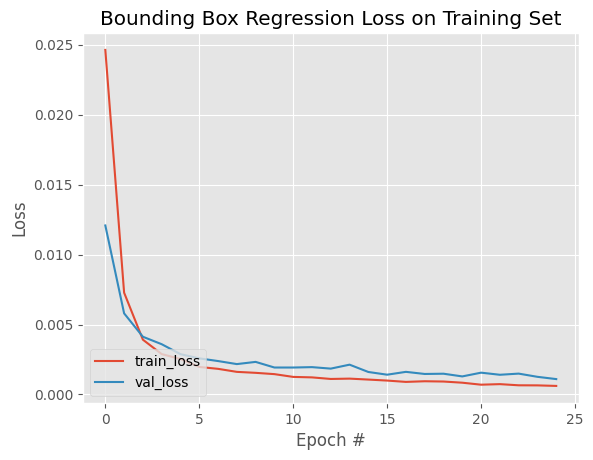

In [9]:
# serialize the model to disk
print("[INFO] saving object detector model...")
model.save(MODEL_PATH, save_format="h5")
# plot the model training history
N = NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)